此任务最关键的一个点是，我该如何处理正样本与负样本数量严重不均衡的问题？

In [1]:
# 导入PyTorch (import torch)
import torch
# 导入数据处理依赖包 (import data set package)
import pandas as pd

# 设置使用CUDA 还是 CPU进行训练（这里可以只用CPU训练）
# set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子，确保结果可复现
# set the random seed for reproducibility
RANDOM_SEED = 42

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\22336\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


In [2]:
# 加载数据集(读取SCV文件)
# load the dataset (read the CSV file) 
df = pd.read_csv(path + "/creditcard.csv")
df.head() # 显示前五行(show the first five rows)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 基础统计信息（basic statistics）
print("数据集的基本统计信息(basic statistics)：") 
print(df.describe())
print("数据集名称，行数，数值，类型(dataset name, rows, values, types)：")
print(df.info()) # 显示数据集的信息，包括数据类型和缺失值情况(show the dataset information, including data types and missing values)

数据集的基本统计信息(basic statistics)：
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380

In [4]:
'''
使用决策树对数据进行预测 (use decision tree to predict data)
'''
#导入sklearn库，用于数据预处理(import sklearn library for data preprocessing)
from sklearn.model_selection import train_test_split
# 拆分特征和标签 (split features and labels)
x=df.drop('Class',axis=1)
y=df['Class']
# 获取数值型和分类型数据 列 (get numeric and categorical data columns)
num_cols=x.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols=x.select_dtypes(include=['object']).columns.tolist()
# 拆分数据集为训练集和测试集 (split the dataset into training and testing sets)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 数据预处理，导入包 (import package)
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
preprocessing = ColumnTransformer([('scaler',StandardScaler(),num_cols),
                                  ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_cols)])

# 训练模型 (使用管道)                  (train the model (use pipeline))
# 导入sklearn库，用于模型训练和评估     (import sklearn library for model training and evaluation)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model=Pipeline([('pre',preprocessing),
               ('model',DecisionTreeClassifier())])
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred) *100 :.2f}')

Accuracy Score: 99.92



LOGISTIC REGRESSION           
Accuracy: 97.64%
Weighted F1: 98.65%
ROC AUC: 0.980
PR AUC: 0.726 (更适合不平衡数据)

Depressed Class Performance:
Precision: 6.31%
Recall: 91.84%
F1: 11.81%


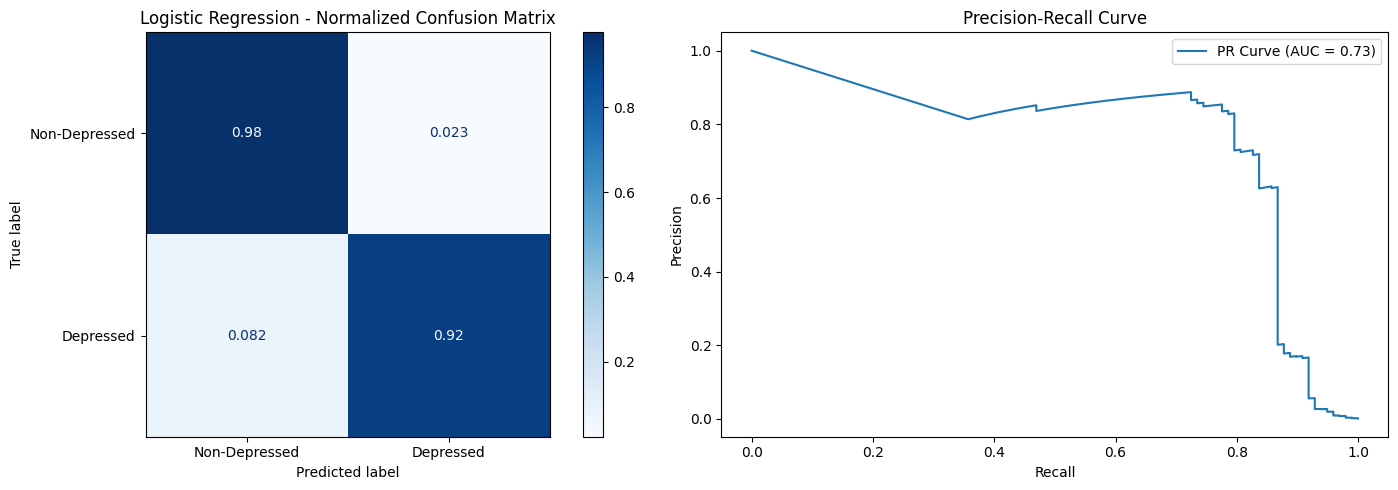


DECISION TREE                 
Accuracy: 99.91%
Weighted F1: 99.91%
ROC AUC: 0.867
PR AUC: 0.546 (更适合不平衡数据)

Depressed Class Performance:
Precision: 74.23%
Recall: 73.47%
F1: 73.85%


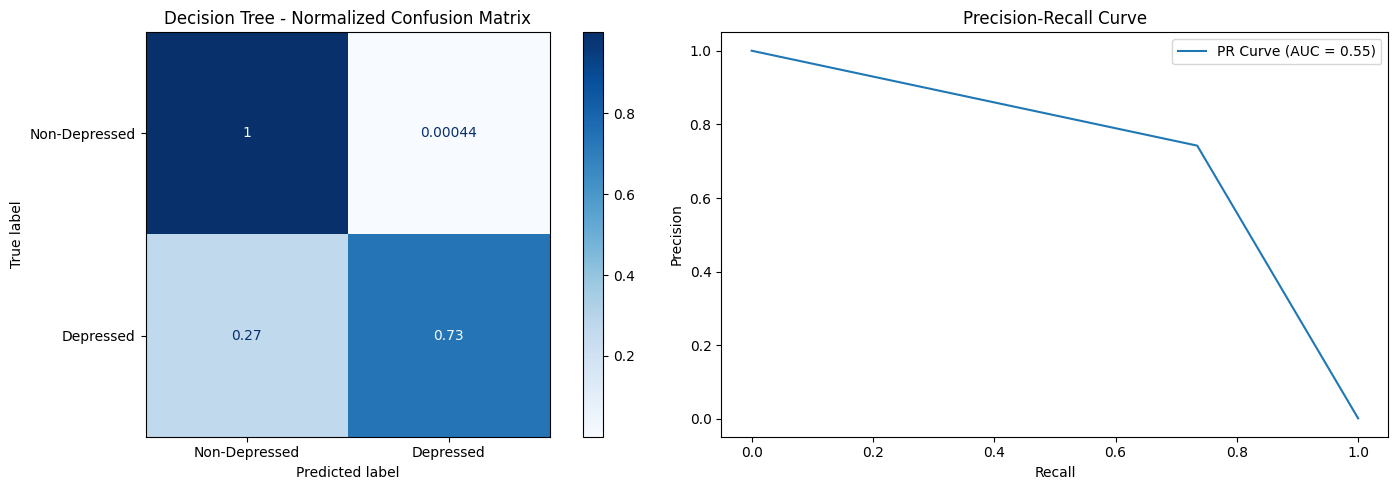


RANDOM FOREST                 
Accuracy: 99.95%
Weighted F1: 99.95%
ROC AUC: 0.953
PR AUC: 0.880 (更适合不平衡数据)

Depressed Class Performance:
Precision: 98.65%
Recall: 74.49%
F1: 84.88%


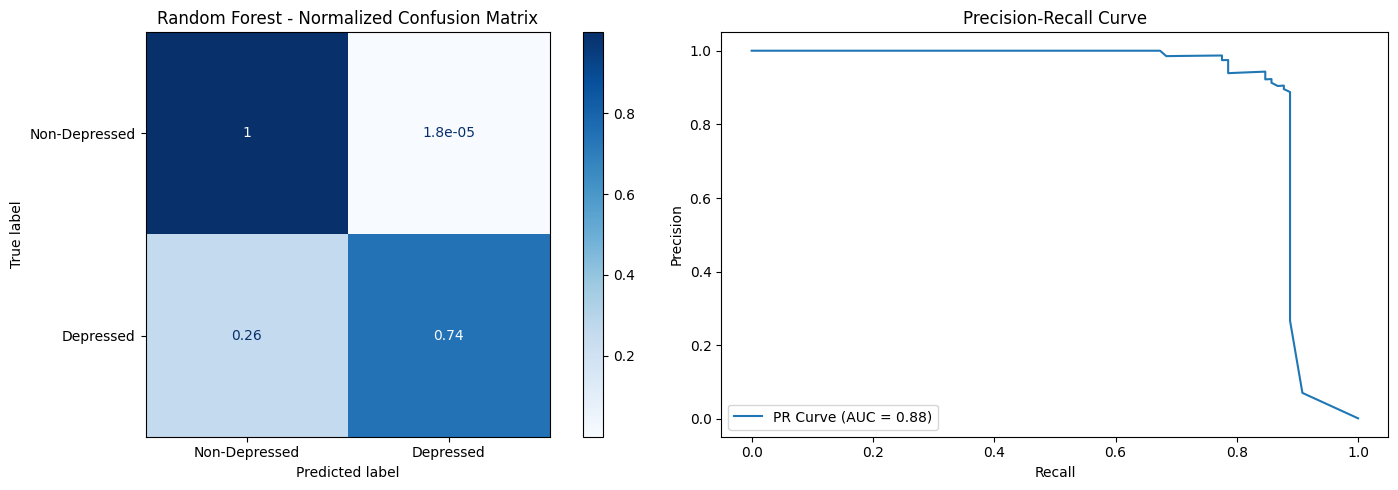


SUPPORT VECTOR CLASSIFIER     
Accuracy: 99.70%
Weighted F1: 99.76%
ROC AUC: 0.981
PR AUC: 0.514 (更适合不平衡数据)

Depressed Class Performance:
Precision: 33.49%
Recall: 74.49%
F1: 46.20%


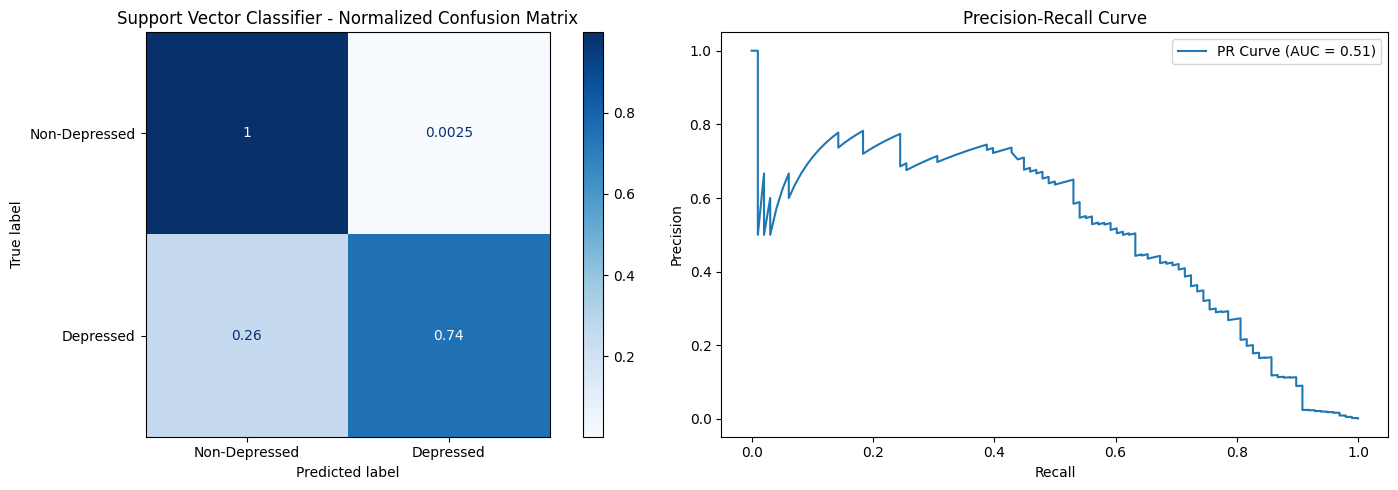


K-NEAREST NEIGHBORS           
Accuracy: 99.95%
Weighted F1: 99.95%
ROC AUC: 0.934
PR AUC: 0.832 (更适合不平衡数据)

Depressed Class Performance:
Precision: 93.83%
Recall: 77.55%
F1: 84.92%


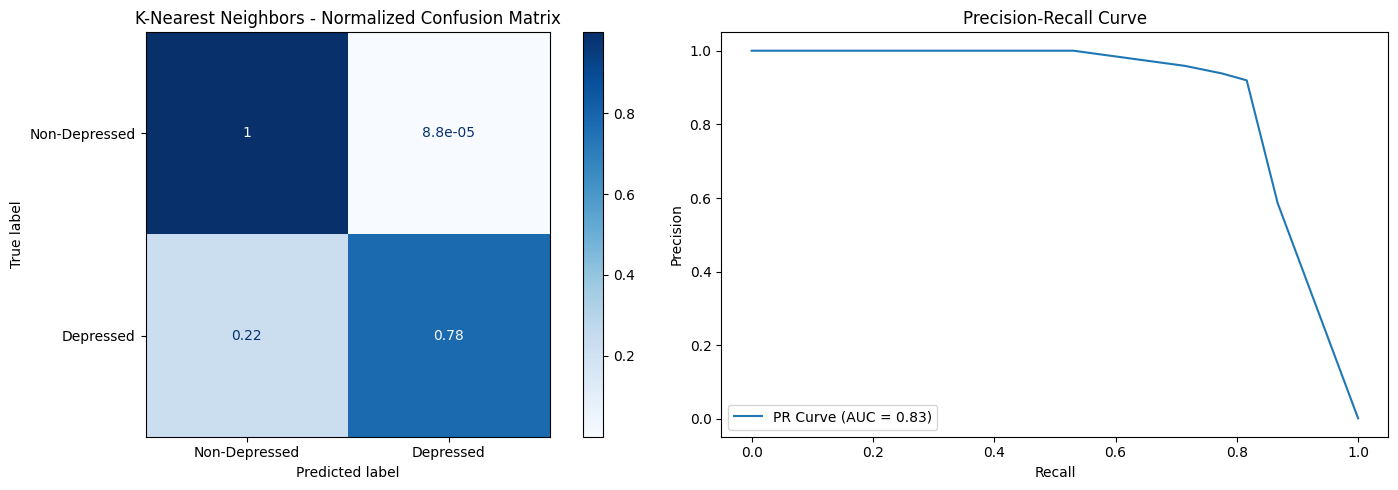


GRADIENT BOOSTING             
Accuracy: 99.89%
Weighted F1: 99.89%
ROC AUC: 0.786
PR AUC: 0.531 (更适合不平衡数据)

Depressed Class Performance:
Precision: 73.75%
Recall: 60.20%
F1: 66.29%


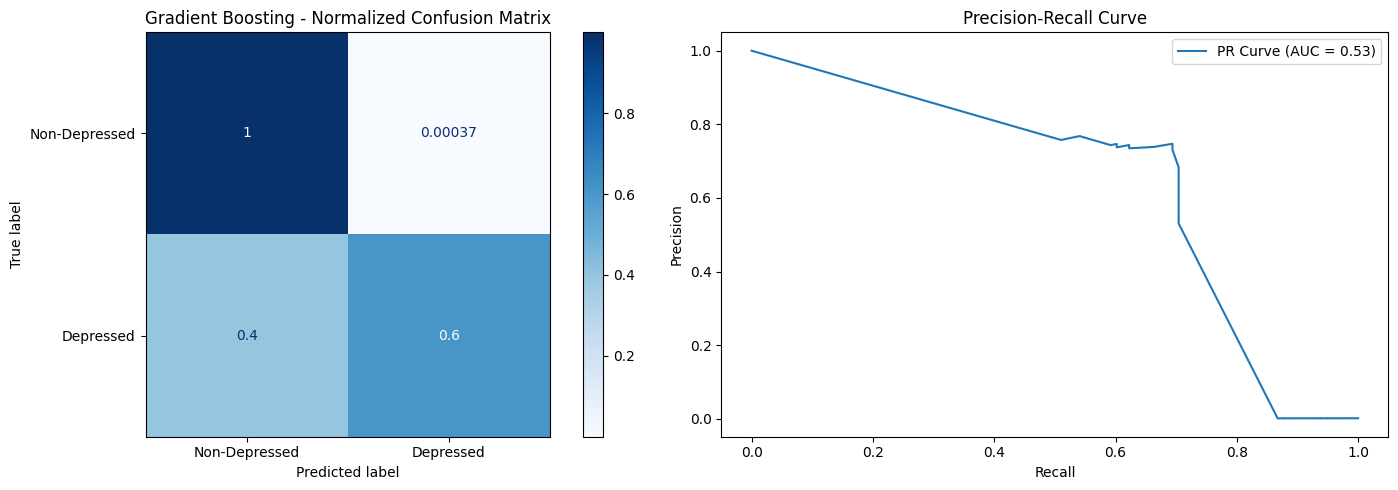

In [5]:
# 导入各种模型 (Import various models)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score


from sklearn.metrics import (
    classification_report, 
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 修改模型配置以支持概率估计（特别是SVC）
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Support Vector Classifier': SVC(probability=True, class_weight='balanced'),  # 启用概率估计
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# 扩展评估指标
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('pre', preprocessing),
        ('model', model)
    ])
    
    # 训练模型
    pipeline.fit(x_train, y_train)
    
    # 预测结果
    y_pred = pipeline.predict(x_test)
    y_proba = pipeline.predict_proba(x_test)[:, 1]  # 获取正类概率
    
    # 基础指标
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 不平衡专用指标
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    # 分类详情报告
    clf_report = classification_report(
        y_test, y_pred, 
        target_names=['Non-Depressed', 'Depressed'],  # 按实际类别命名
        output_dict=True
    )
    
    # 存储结果
    results[name] = {
        'accuracy': acc,
        'f1_weighted': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'report': clf_report
    }
    
    # 打印关键指标
    print(f"\n{name.upper():<30}")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Weighted F1: {f1 * 100:.2f}%")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"PR AUC: {pr_auc:.3f} (更适合不平衡数据)")
    
    # 展示少数类（抑郁症）的关键指标
    depressed_metrics = clf_report['Depressed']
    print("\nDepressed Class Performance:")
    print(f"Precision: {depressed_metrics['precision']*100:.2f}%")
    print(f"Recall: {depressed_metrics['recall']*100:.2f}%")
    print(f"F1: {depressed_metrics['f1-score']*100:.2f}%")

    # 可视化分析
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=['Non-Depressed', 'Depressed'])
    disp.plot(ax=ax[0], cmap='Blues')
    ax[0].set_title(f'{name} - Normalized Confusion Matrix')
    
    # PR曲线
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ax[1].plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()